# Inpaint Diffusion

Image inpainting is the task of reconstructing missing parts of an image with the help of context provided by the remaining parts of the image, and a prompt. In the real world, inpainting is commonly used in features like object removal and noise/damage removal.

Inpainting is the foundational tool used in creating the "infinite zoom" animation.

In this implementation, we make use of RunwayML's model for stable diffusion inpainting.

### Install and Import required packages

In [ ]:
!pip install stablefused ipython

In [ ]:
import numpy as np
import torch
import math
from IPython.display import Video, display
from PIL import Image
from stablefused import InpaintDiffusion, InpaintWalkType, Scheduler
from stablefused.utils import image_grid, pil_to_video

### Initialize model and parameters

We use RunwayML's Stable Diffusion 1.5 checkpoint and initialize our Inpainting model, and some other parameters. Play around with different prompts and see what you get! You can comment out the seed part if you want to generate new random images each time you run the notebook.

In [ ]:
model_id = "runwayml/stable-diffusion-inpainting"
model = InpaintDiffusion(model_id=model_id, torch_dtype=torch.float16, revision="fp16")
model.enable_attention_slicing()
model.enable_slicing()
model.enable_tiling()

In [ ]:
model.set_scheduler(Scheduler.DPM_MULTISTEP)

In [ ]:
prompt = [
    "Digital illustration of a mythical creature, high quality, realistic, 8k",
    "Digital illustration of a mythical creature, high quality, realistic, 8k",
    "Digital illustration of a dragon, high quality, realistic, octane render, 8k",
    "Digital illustration of a ferocious lion, high quality, realistic, octane render, 8k",
    "Digital illustration of an evil white rabbit, high quality, realistic, 8k",
    "Digital illustration of samurai with a moon-like object in the background, high quality, realistic, octane render, 8k",
]
negative_prompt = "cartoon, unrealistic, blur, boring background, deformed, disfigured, low resolution, unattractive"
num_images = len(prompt)
seed = 420

torch.manual_seed(seed)
np.random.seed(seed)

Loading the original image and the mask into the notebook. The mask contains black and white pixels. The blackened portion represents the parts where information is retained, and the white portion represents the parts where inpainting is to be done.

Image and Prompt credits: https://mspoweruser.com/best-stable-diffusion-prompts/#7_Samurai_and_the_Mystical

Original and mask image:


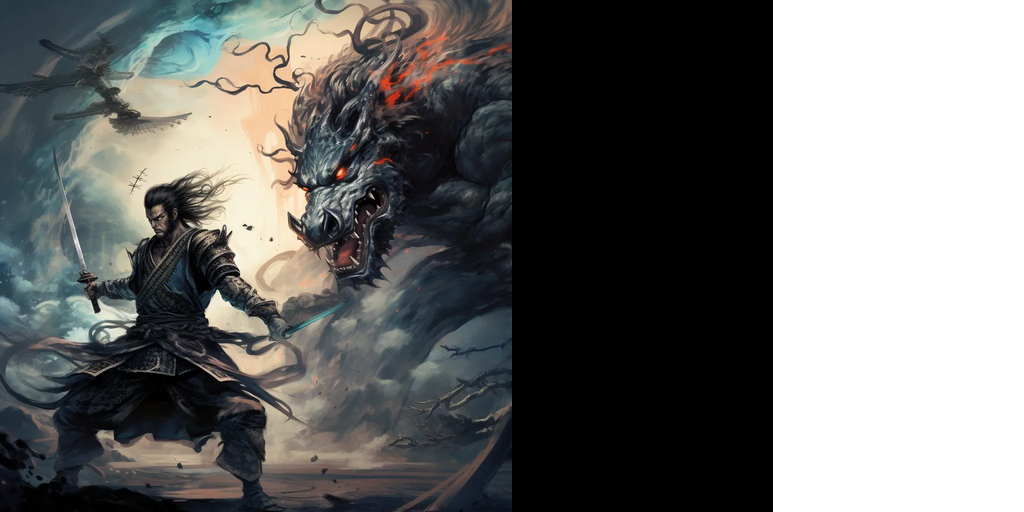

In [ ]:
image_filename = "image.png"
mask_filename = "mask.png"

image = [Image.open(image_filename)] * num_images
mask = [Image.open(mask_filename)] * num_images

print("Original and mask image:")
image_grid([image[0], mask[0]], rows=1, cols=2)

Inpaint the model using the image, mask and prompts.

In [ ]:
images = model(
    prompt=prompt,
    negative_prompt=[negative_prompt] * num_images,
    image=image,
    mask=mask,
    num_inference_steps=20,
    start_step=2,
    guidance_scale=12.0,
)

Display the images in a grid:

In [ ]:
image_grid(images, rows=2, cols=len(prompt) // 2)

### Infinite Zoom In

In [ ]:
prompt = "A painting of a cat, in the style of Vincent Van Gogh, hanging in a room"
negative_prompt = "cartoon, unrealistic, blur, boring background, deformed, disfigured, low resolution, unattractive"
seed = 31337

torch.manual_seed(seed)
np.random.seed(seed)

Original image:


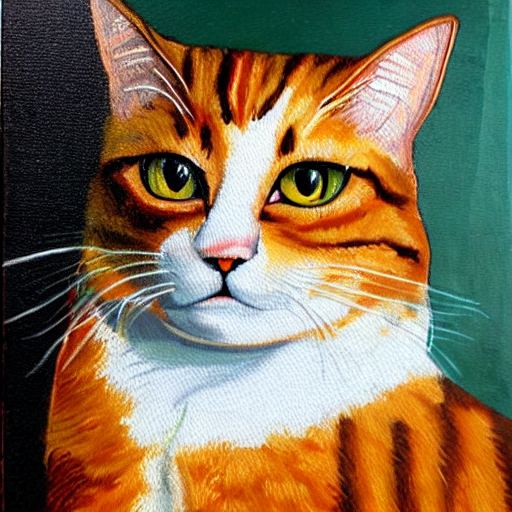

In [ ]:
image_filename = "image2.png"
image = Image.open(image_filename)

print("Original image:")
image_grid([image], rows=1, cols=1)

In [ ]:
images = model.walk(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=image,
    walk_type=InpaintWalkType.BACKWARD,
    height_translation_per_step=48,
    width_translation_per_step=48,
    num_inpainting_steps=24,
    interpolation_steps=30,
    num_inference_steps=20,
    guidance_scale=12.0,
)

In [ ]:
pil_to_video(images[::-1], "infinite_zoom_in.mp4", fps=120)

In [ ]:
display(Video("infinite_zoom_in.mp4", embed=True))

### Combination of panning and zooming

In [168]:
# There will be in-built support for this somewhat complex logic in the future
prompt_panning = (
    "Post-apocalyptic world with ruins, overgrown vegetation, and a lone survivor"
)
prompt_zooming = prompt_panning  # Could be anything else

num_pan_translations = 8
num_zoom_translations = 2
pan_walk = []
zoom_walk = []
for walk in [
    InpaintWalkType.RIGHT,
    InpaintWalkType.DOWN,
    InpaintWalkType.LEFT,
    InpaintWalkType.UP,
]:
    pan_walk.extend([walk] * num_pan_translations)
zoom_walk = [InpaintWalkType.BACKWARD] * num_zoom_translations
pan_inpainting_steps = len(pan_walk)
zoom_inpainting_steps = len(zoom_walk)

walk = pan_walk + zoom_walk
num_inpainting_steps = pan_inpainting_steps + zoom_inpainting_steps
prompt = [prompt_panning] * pan_inpainting_steps + [
    prompt_zooming
] * zoom_inpainting_steps
num_images = len(prompt)

seed = 1
torch.manual_seed(seed)
np.random.seed(seed)

Original image:


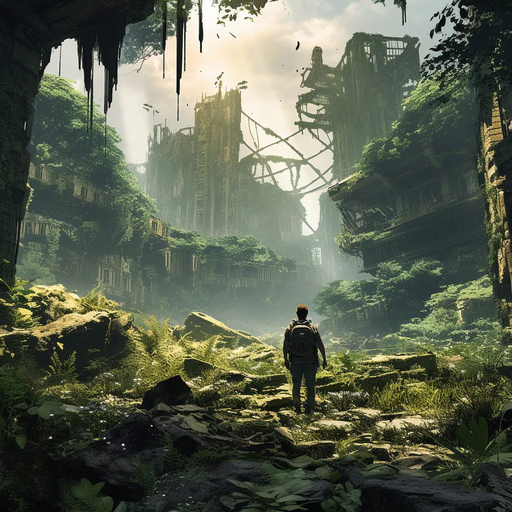

In [169]:
image_filename = "image3.png"
image = Image.open(image_filename)

print("Original image:")
image_grid([image], rows=1, cols=1)

In [ ]:
images = model.walk(
    prompt=prompt,
    negative_prompt=[negative_prompt] * num_images,
    image=image,
    walk_type=walk,
    image_height=512,
    image_width=512,
    height_translation_per_step=48,
    width_translation_per_step=48,
    num_inpainting_steps=num_inpainting_steps,
    interpolation_steps=30,
    num_inference_steps=12,
    guidance_scale=8.0,
)

In [171]:
pil_to_video(images, "pan_and_zoom.mp4", fps=120)

In [ ]:
display(Video("pan_and_zoom.mp4", embed=True))